In [1]:
from tqdm import tqdm_notebook, tqdm
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from dotenv import load_dotenv
from datetime import datetime
from pathlib import Path
from time import sleep
import pandas as pd
import os
import numpy as np

In [2]:
# Alternative?  https://stackoverflow.com/questions/48775841/pandas-ema-not-matching-the-stocks-ema
# ta.ema shown at the end of that page.  Is sorting index necessary?
#import pandas_ta as ta
#
#data["EMA20"] = ta.ema(df2["Close"], length=20)

def add_EMA(price, day):
    return price.ewm(span=day).mean()

# function to check for EMA crossing
def check_EMA_crossing(df):
    # condition 1: EMA18 is higher than EMA50 at the last trading day
    cond_1 = df.iloc[-1]['EMA18'] > df.iloc[-1]['EMA50']
    # condition 2: EMA18 is lower than EMA50 the previous day
    cond_2 = df.iloc[-2]['EMA18'] < df.iloc[-2]['EMA50']
    # condition 3: to filter out stocks with less than 50 candles
    cond_3 = len(df.index) > 50 
    # will return True if all 3 conditions are met
    return (cond_1 and cond_2 and cond_3)

In [3]:
load_dotenv()

sp500_tickers_df = pd.read_csv(Path("dataset/symbols.csv"), header=None)
#display(sp500_tickers_df.head(3))
#display(sp500_tickers_df.tail(3))
sp500_tickers = sp500_tickers_df.loc[:,0]
       
# Setting the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_api_secret_key = os.getenv('ALPACA_SECRET_KEY')

display(type(alpaca_api_key))
display(type(alpaca_api_secret_key))

# Create the Alpaca tradeapi.REST object
alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_api_secret_key, api_version = "v2")

# Set start and end dates of 10 years back from your current date
timeframe="1D"
today=pd.Timestamp.now()
start_date = pd.Timestamp(today - pd.Timedelta(days=365), tz="America/New_York").isoformat()
end_date = pd.Timestamp(today).isoformat()
max_rows=365

str

str

In [4]:
def get_alpaca_price(ticker):
    ticker_df=alpaca_api.get_barset(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=max_rows
    ).df
    
    return (ticker_df)

In [5]:
# price_chart_df = get_alpaca_price('NLSN')
# price_chart_df.head()
# close_df = price_chart_df.xs('close',level=1,axis=1)
# close_df = pd.DataFrame(columns = ['close'])
# close_df['close'] = price_chart_df['NLSN']['close']
# close_df.head()
# display(close_df['close'])

In [6]:
# for loop is throttled with sleep() to keep alpacas calls under 200/minute.

# Alternative design would be getting all 500 tickers in one call to get_barset(),
# and extracting the each_stock 'close' column in this loop

# Preliminary ticker list after screening based on EMA
screened_list = [] 

stock_list = sp500_tickers
#for each_stock in tqdm_notebook(stock_list):
for each_stock in tqdm(stock_list):
    #print(each_stock)
    # Step 1: get stock price for each stock
    price_chart_df = get_alpaca_price(each_stock)
    price_chart_df.head()
    close_df = pd.DataFrame(columns = ['close'])
    close_df['close'] = price_chart_df[each_stock]['close']

    # Step 2: add technical indicators (in this case EMA)
    close_df['EMA18']=add_EMA(close_df['close'],18)
    close_df['EMA50']=add_EMA(close_df['close'],50)
    close_df['EMA100']=add_EMA(close_df['close'],100)
    # if all 3 conditions are met, add stock into screened list
    if check_EMA_crossing(close_df):
      screened_list.append(each_stock)
    sleep(0.2)

# 10-year history will be pulled for each ticker in then list, then run Monte Carlo, and other ta (beta, sharpes, etc)
# return (screened_list)
print(screened_list)
portfolio_1 = screened_list

  0%|          | 0/505 [00:00<?, ?it/s]

['BA', 'DISCA', 'EVRG', 'GL', 'MA']


In [7]:
portfolio_1_df=pd.DataFrame(portfolio_1)
portfolio_1_df

price_chart_df = get_alpaca_price(['BA', 'DISCA', 'EVRG', 'GL', 'MA'])
price_chart_df.head()

BA                                       DISCA  \
                             open    high       low   close     volume   open   
time                                                                            
2020-11-16 00:00:00-05:00  194.56  202.94  191.3501  202.40   76791148  23.70   
2020-11-17 00:00:00-05:00  200.25  211.20  196.0500  210.02   73949349  23.59   
2020-11-18 00:00:00-05:00  223.02  223.02  203.0000  203.20  121049594  24.32   
2020-11-19 00:00:00-05:00  200.45  209.44  199.9007  205.56   66289637  24.14   
2020-11-20 00:00:00-05:00  204.59  206.58  199.1700  199.62   34789469  24.90   

                                                          ...     GL         \
                            high     low  close   volume  ...   open   high   
time                                                      ...                 
2020-11-16 00:00:00-05:00  24.37  23.615  24.06  7559471  ...  94.57  94.97   
2020-11-17 00:00:00-05:00  24.57  23.470  24.30  4183121  ...  92.99  94.22   
2020-11-18 00:00:00-05:00  25.05  24.100  24.51  6321248  ...  93.89  95.21   
2020-11-19 00:00:00-05:00  25.19  24.140  25.02  5647841  ...  91.75  93.61   
2020-11-20 00:00:00-05:00  25.58  24.750  25.46  7317042  ...  92.98  93.73   

                                                       MA                    \
                               low  close  volume    open     high      low   
time                                                                          
2020-11-16 00:00:00-05:00  92.9300  93.50  281358  341.80  342.650  333.170   
2020-11-17 00:00:00-05:00  92.2450  93.79  547256  333.17  337.770  330.720   
2020-11-18 00:00:00-05:00  92.3800  92.38  624333  336.53  340.950  334.855   
2020-11-19 00:00:00-05:00  91.2025  93.35  630365  335.49  339.160  331.420   
2020-11-20 00:00:00-05:00  92.5400  93.22  602223  334.78  335.155  323.220   

                                            
                            close   volume  
time                                        
2020-11-16 00:00:00-05:00  335.58  6057040  
2020-11-17 00:00:00-05:00  336.50  6146448  
2020-11-18 00:00:00-05:00  335.94  5687703  
2020-11-19 00:00:00-05:00  333.87  4452422  
2020-11-20 00:00:00-05:00  323.29  6843330  

[5 rows x 25 columns]

In [8]:
#creatge DAtaFrame for Closing prices
#get closiing prices for the list of stocks
closing_prices_df=pd.DataFrame()
closing_prices_df['BA']=price_chart_df['BA']['close']
closing_prices_df['DISCA']=price_chart_df['DISCA']['close']
closing_prices_df['EVRG']=price_chart_df['EVRG']['close']
closing_prices_df['GL']=price_chart_df['GL']['close']
closing_prices_df['MA']=price_chart_df['MA']['close']

#droping time component of the date index
closing_prices_df.index=closing_prices_df.index.date
closing_prices_df.head()


,BA,DISCA,EVRG,GL,MA
2020-11-16,202.40,24.06,57.61,93.50,335.58
2020-11-17,210.02,24.30,56.58,93.79,336.50
2020-11-18,203.20,24.51,55.01,92.38,335.94
2020-11-19,205.56,25.02,53.69,93.35,333.87
2020-11-20,199.62,25.46,54.51,93.22,323.29


In [9]:
#calculate daily returns
daily_returns_df=closing_prices_df.pct_change().dropna()
display(daily_returns_df.head())
display(daily_returns_df.tail())



,BA,DISCA,EVRG,GL,MA
2020-11-17,0.037648,0.009975,-0.017879,0.003102,0.002742
2020-11-18,-0.032473,0.008642,-0.027748,-0.015034,-0.001664
2020-11-19,0.011614,0.020808,-0.023996,0.010500,-0.006162
2020-11-20,-0.028897,0.017586,0.015273,-0.001393,-0.031689
2020-11-23,0.058912,0.041634,0.008476,0.015018,0.028086


,BA,DISCA,EVRG,GL,MA
2021-11-10,-0.010598,0.027017,0.008732,0.004874,0.038620
2021-11-11,0.004440,0.031787,-0.001700,0.006252,-0.009685
2021-11-12,0.007064,-0.011686,-0.001394,0.011141,0.025578
2021-11-15,0.054894,0.004658,0.017212,0.002013,-0.005776
2021-11-16,-0.031188,-0.011412,-0.003049,0.000529,0.022769


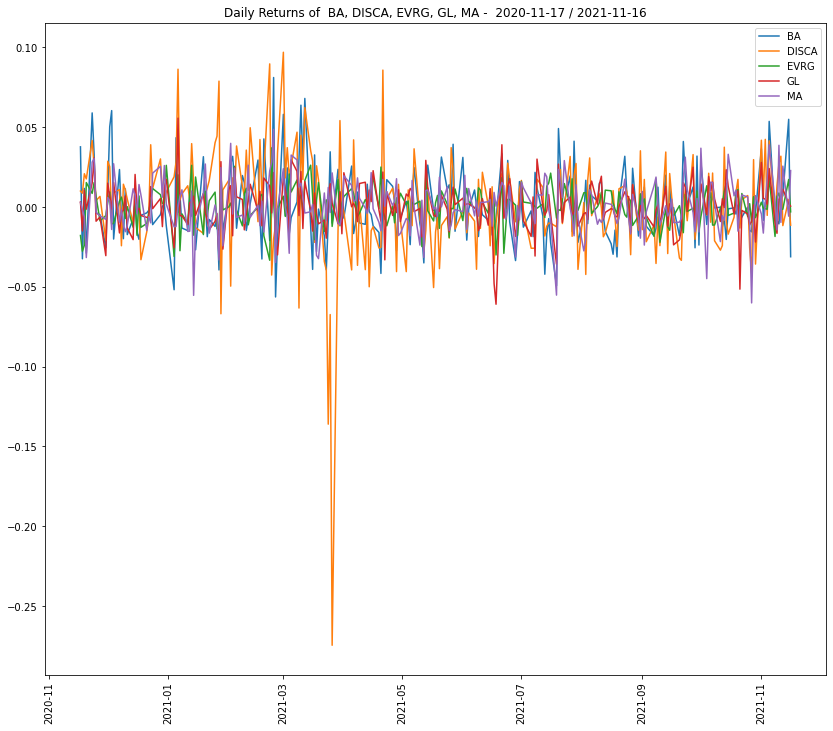

In [10]:
#visualize daily returns 
daily_returns_plot=daily_returns_df.plot(
    figsize=(14, 12), 
    title="Daily Returns of  BA, DISCA, EVRG, GL, MA -  2020-11-17 / 2021-11-16", 
    rot=90
)


<AxesSubplot:title={'center':'Daily Returns Histogram'}, ylabel='Frequency'>

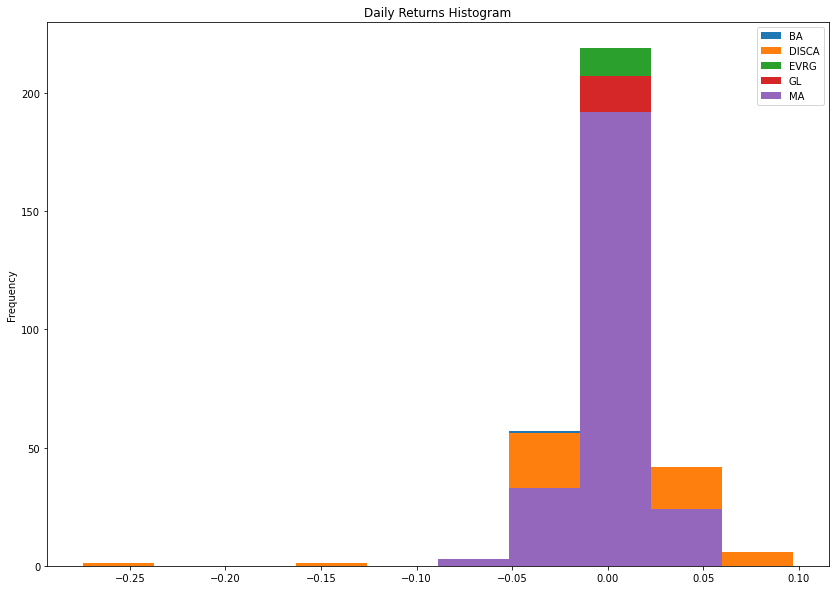

In [11]:
daily_returns_df.plot.hist(title="Daily Returns Histogram", figsize= (14, 10)) 

<AxesSubplot:title={'center':'Daily Returns box'}>

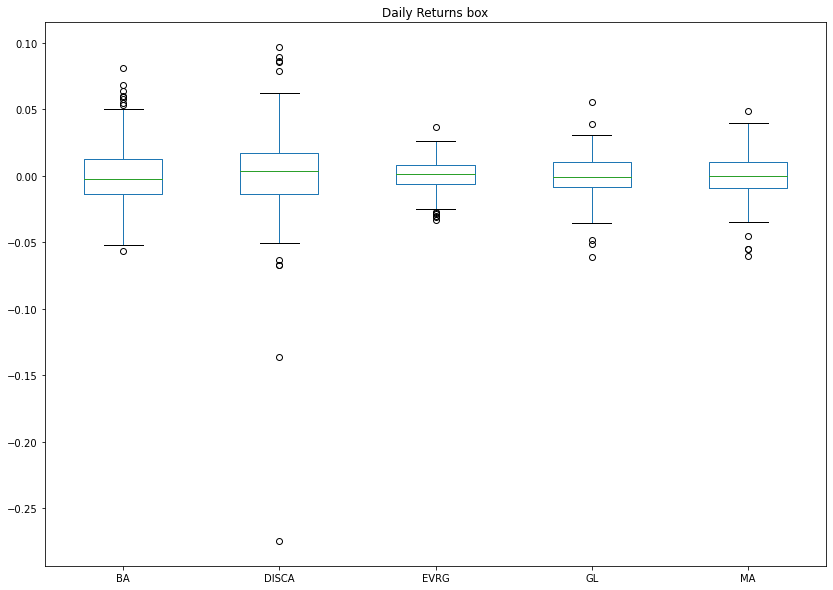

In [12]:
daily_returns_df.plot.box(title="Daily Returns box", figsize= (14, 10))

In [13]:
daily_returns_df.describe()


,BA,DISCA,EVRG,GL,MA
count,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.000675,0.001138,0.000570,0.000156,0.000519
std,0.022047,0.032944,0.011516,0.014730,0.016454
min,-0.056382,-0.274584,-0.033390,-0.060946,-0.060108
25%,-0.013341,-0.013929,-0.005918,-0.008589,-0.008828
50%,-0.002656,0.003452,0.001488,-0.000588,-0.000071
75%,0.012403,0.017338,0.008324,0.010048,0.010677
max,0.081082,0.096908,0.037024,0.055646,0.048642


In [14]:
# The number of trading days is set to 252 for use throughout these calculations
trading_days = 252

# Calculate the annual average daily returns for the crypto currencies
# Use the Pandas mean function to calculate the average daily return for each cryptocurrency 
# Then multiply that value by the number of trading days in a year, using the trading_days variable set above 
annual_average_returns = daily_returns_df.mean() * trading_days

# Sort the annual average returns for the cryptocurrencies from lowest to highest
annual_average_returns.sort_values()


GL       0.039332
MA       0.130867
EVRG     0.143521
BA       0.169978
DISCA    0.286697
dtype: float64

In [15]:
#Calculate the annualized standard deviation for the Stocks
# Use the Pandas std function to calculate the standard deviation for each cryptocurrency
# Multiply the standard deviation by the square root (using the NumPy sqrt function) of the number of trading days
annual_standard_deviation = daily_returns_df.std() * np.sqrt(252)

# Sort the annual standard deviations for the cryptocurrencies from lowest to highest
annual_standard_deviation.sort_values()


EVRG     0.182808
GL       0.233826
MA       0.261198
BA       0.349991
DISCA    0.522968
dtype: float64

In [40]:
# Create correlation table for all data in closing_prices_df
df_corr = closing_prices_df.corr()
print(df_corr.head())

             BA     DISCA      EVRG        GL        MA
BA     1.000000  0.332264  0.231079  0.619895  0.652876
DISCA  0.332264  1.000000 -0.396841  0.283612  0.166648
EVRG   0.231079 -0.396841  1.000000  0.133712  0.488224
GL     0.619895  0.283612  0.133712  1.000000  0.499945
MA     0.652876  0.166648  0.488224  0.499945  1.000000


<AxesSubplot:>

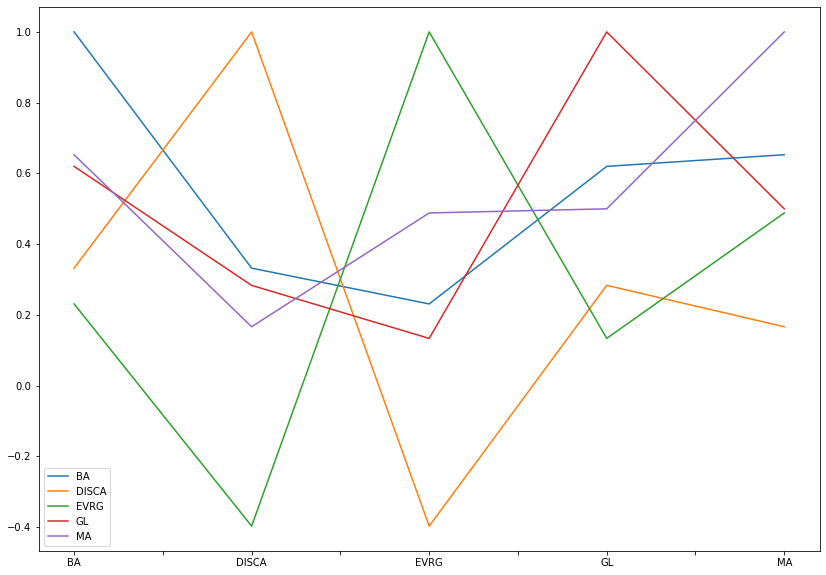

In [41]:
# Visualize inner values of dataframe (numpy array of columns and rows)
# Specify figure and define axes using parameters(111) : one subplot is 1x1 for plot 1)
df_corr.plot(figsize=(14, 10))

<AxesSubplot:title={'center':'BA Probability distribution'}, ylabel='Frequency'>

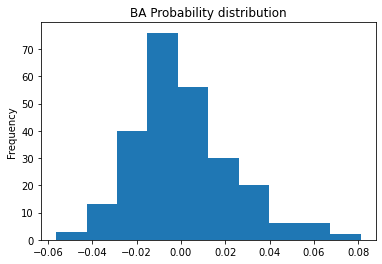

In [16]:
#distribution of BA percent change in closing price
daily_returns_df['BA'].plot.hist(title='BA Probability distribution')

<AxesSubplot:title={'center':'D Probability distribution'}, ylabel='Frequency'>

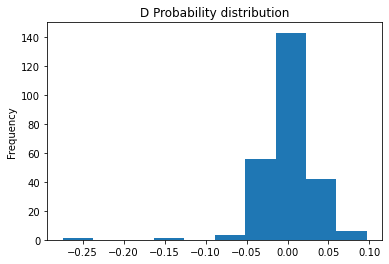

In [17]:
#distribution of D percent change in closing price
daily_returns_df['DISCA'].plot.hist(title='D Probability distribution')

<AxesSubplot:title={'center':'EVRG Probability distribution'}, ylabel='Frequency'>

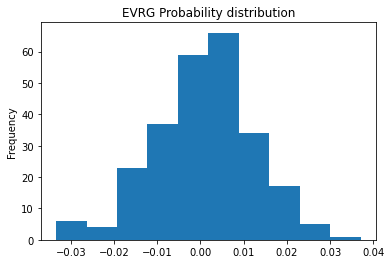

In [18]:
#distribution of EVRFG percent change in closing price
daily_returns_df['EVRG'].plot.hist(title='EVRG Probability distribution')

<AxesSubplot:title={'center':'GL Probability distribution'}, ylabel='Frequency'>

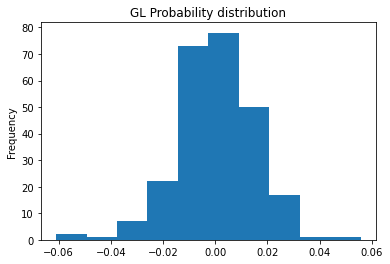

In [19]:
#distribution of GL percent change in closing price
daily_returns_df['GL'].plot.hist(title='GL Probability distribution')

<AxesSubplot:title={'center':'MA Probability distribution'}, ylabel='Frequency'>

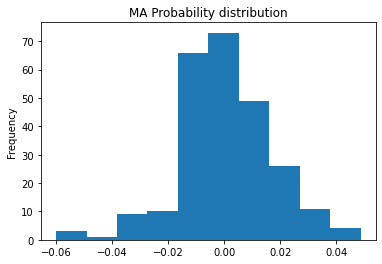

In [20]:
#distribution of MA percent change in closing price
daily_returns_df['MA'].plot.hist(title='MA Probability distribution')

<AxesSubplot:title={'center':'Density plot for tickers in portfolio'}, ylabel='Density'>

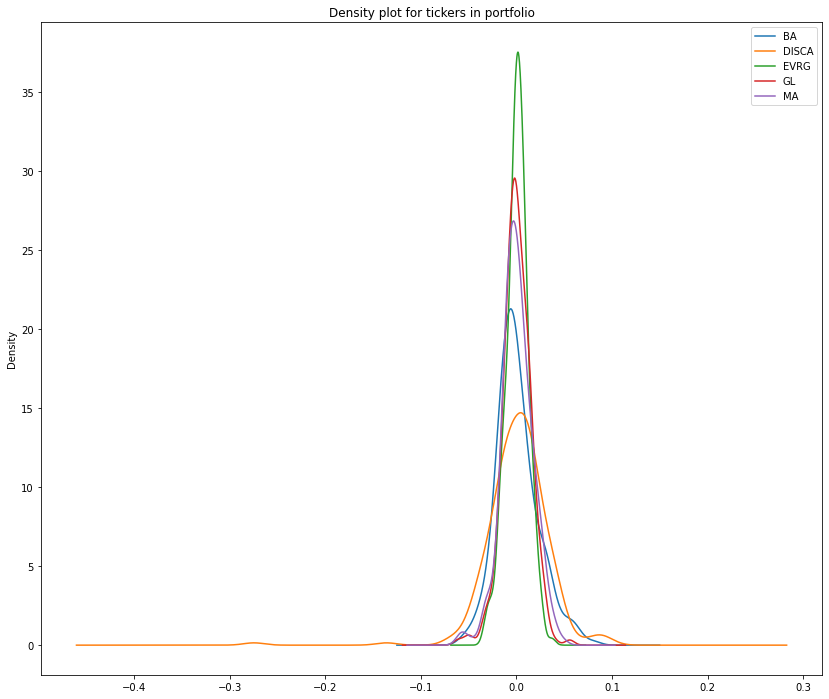

In [21]:
#distribution of daily returns data for the tickers in portfolio
daily_returns_df.plot.density(figsize=(14, 12), title="Density plot for tickers in portfolio")

In [22]:
#Configure a Monte Carlo simulation to forecast five years cumulative returns

MC_fiveyear = MCSimulation(
  portfolio_data = price_chart_df,
  weights = [.20, .20, .20, .20, .20],
  num_simulation = 500,
  num_trading_days = 252*5
)

MC_fiveyear.portfolio_data.head().dropna()

BA                                       \
                             open    high       low   close     volume   
time                                                                     
2020-11-17 00:00:00-05:00  200.25  211.20  196.0500  210.02   73949349   
2020-11-18 00:00:00-05:00  223.02  223.02  203.0000  203.20  121049594   
2020-11-19 00:00:00-05:00  200.45  209.44  199.9007  205.56   66289637   
2020-11-20 00:00:00-05:00  204.59  206.58  199.1700  199.62   34789469   

                                        DISCA                       ...  \
                          daily_return   open   high    low  close  ...   
time                                                                ...   
2020-11-17 00:00:00-05:00     0.037648  23.59  24.57  23.47  24.30  ...   
2020-11-18 00:00:00-05:00    -0.032473  24.32  25.05  24.10  24.51  ...   
2020-11-19 00:00:00-05:00     0.011614  24.14  25.19  24.14  25.02  ...   
2020-11-20 00:00:00-05:00    -0.028897  24.90  25.58  24.75  25.46  ...   

                                GL                                  MA  \
                               low  close  volume daily_return    open   
time                                                                     
2020-11-17 00:00:00-05:00  92.2450  93.79  547256     0.003102  333.17   
2020-11-18 00:00:00-05:00  92.3800  92.38  624333    -0.015034  336.53   
2020-11-19 00:00:00-05:00  91.2025  93.35  630365     0.010500  335.49   
2020-11-20 00:00:00-05:00  92.5400  93.22  602223    -0.001393  334.78   

                                                                           
                              high      low   close   volume daily_return  
time                                                                       
2020-11-17 00:00:00-05:00  337.770  330.720  336.50  6146448     0.002742  
2020-11-18 00:00:00-05:00  340.950  334.855  335.94  5687703    -0.001664  
2020-11-19 00:00:00-05:00  339.160  331.420  333.87  4452422    -0.006162  
2020-11-20 00:00:00-05:00  335.155  323.220  323.29  6843330    -0.031689  

[4 rows x 30 columns]

In [23]:
#Run a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear.calc_cumulative_return()


Running Monte Carlo simulation number:


  0%|          | 0/500 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011559,0.986440,1.016945,0.993791,1.010702,0.998880,1.007919,0.993593,1.005106,0.989939,...,0.981686,0.984582,0.996196,0.998969,0.996099,0.995074,1.002245,0.993040,0.996123,1.003252
2,1.024969,0.981901,1.018894,0.981899,1.000758,1.012970,1.020065,1.002640,0.997864,0.994124,...,0.981300,1.000853,0.983728,1.002522,0.990344,1.010177,1.023241,0.983309,0.998851,1.006033
3,1.021100,0.979365,1.004117,0.979270,1.007049,1.009126,1.017518,1.012701,1.005460,1.003934,...,0.985682,1.008683,0.978487,1.012030,0.990210,1.011612,1.008745,0.982533,0.992929,1.001646
4,1.017767,0.986494,0.986144,0.991244,1.005757,1.012771,1.011814,1.015791,0.995517,0.993689,...,0.980791,1.010554,0.987111,1.002417,0.985438,0.990360,1.014668,0.983751,1.005288,0.999562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.900899,2.878617,1.576384,2.670212,1.203659,2.412819,3.869047,2.389588,2.010864,3.200214,...,1.944168,1.895910,1.955570,2.284518,2.287012,2.647533,1.725175,2.101662,2.010966,2.246068
1257,1.914624,2.854900,1.606398,2.641358,1.196912,2.416105,3.842957,2.323603,2.005868,3.215342,...,1.937887,1.877310,1.930837,2.292609,2.301816,2.642962,1.772846,2.092303,2.012953,2.306834
1258,1.925623,2.836747,1.604503,2.687207,1.214697,2.399216,3.818957,2.309617,2.030552,3.223517,...,1.966541,1.878333,1.941131,2.332732,2.326581,2.623875,1.783997,2.071334,2.017549,2.315309
1259,1.955322,2.887235,1.605434,2.736264,1.220834,2.373797,3.848101,2.299293,2.059118,3.243928,...,1.953596,1.862525,1.927955,2.324957,2.331522,2.613049,1.775701,2.055230,2.002472,2.326496


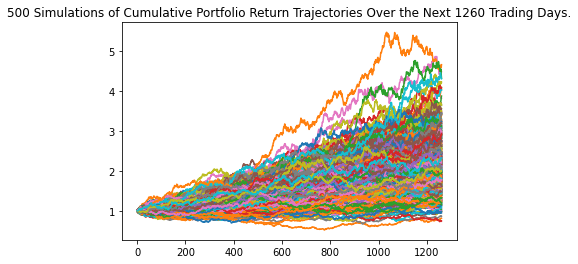

In [24]:
# Plot simulation outcomes
MC_sim_line_plot = MC_fiveyear.plot_simulation()



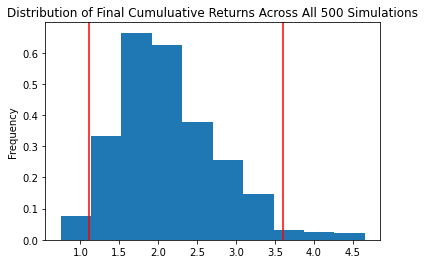

In [25]:
# Plot probability distribution and confidence intervals
MC_sim_dist_plot = MC_fiveyear.plot_distribution()



In [26]:
# Generate summary statistics from the Monte Carlo simulation
# Set the summary statistics equal to a variable for future use
MC_summary_statistics = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics Series
print(MC_summary_statistics)


count           500.000000
mean              2.146652
std               0.655709
min               0.743114
25%               1.695390
50%               2.048718
75%               2.473226
max               4.658100
95% CI Lower      1.113724
95% CI Upper      3.603875
Name: 1260, dtype: float64


In [27]:
# Using the lower and upper `95%` confidence intervals from the summary statistics,
# calculate the range of the probable cumulative returns for a $10,000 investment
ci_95_lower_cumulative_return = MC_summary_statistics[8] * 10000
ci_95_upper_cumulative_return = MC_summary_statistics[9] * 10000


# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
  f" over the next 5 years will end within in the range of"
  f" ${ci_95_lower_cumulative_return: .2f} and ${ci_95_upper_cumulative_return: .2f}.")


There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 5 years will end within in the range of $ 11137.24 and $ 36038.75.


In [28]:
#Configure a Monte Carlo simulation to forecast Three years cumulative returns
MC_threeyear = MCSimulation(
  portfolio_data = price_chart_df,
  weights = [.20, .20, .20, .20, .20],
  num_simulation = 500,
  num_trading_days = 252*3
)

MC_fiveyear.portfolio_data.head().dropna()

BA                                       \
                             open    high       low   close     volume   
time                                                                     
2020-11-17 00:00:00-05:00  200.25  211.20  196.0500  210.02   73949349   
2020-11-18 00:00:00-05:00  223.02  223.02  203.0000  203.20  121049594   
2020-11-19 00:00:00-05:00  200.45  209.44  199.9007  205.56   66289637   
2020-11-20 00:00:00-05:00  204.59  206.58  199.1700  199.62   34789469   

                                        DISCA                       ...  \
                          daily_return   open   high    low  close  ...   
time                                                                ...   
2020-11-17 00:00:00-05:00     0.037648  23.59  24.57  23.47  24.30  ...   
2020-11-18 00:00:00-05:00    -0.032473  24.32  25.05  24.10  24.51  ...   
2020-11-19 00:00:00-05:00     0.011614  24.14  25.19  24.14  25.02  ...   
2020-11-20 00:00:00-05:00    -0.028897  24.90  25.58  24.75  25.46  ...   

                                GL                                  MA  \
                               low  close  volume daily_return    open   
time                                                                     
2020-11-17 00:00:00-05:00  92.2450  93.79  547256     0.003102  333.17   
2020-11-18 00:00:00-05:00  92.3800  92.38  624333    -0.015034  336.53   
2020-11-19 00:00:00-05:00  91.2025  93.35  630365     0.010500  335.49   
2020-11-20 00:00:00-05:00  92.5400  93.22  602223    -0.001393  334.78   

                                                                           
                              high      low   close   volume daily_return  
time                                                                       
2020-11-17 00:00:00-05:00  337.770  330.720  336.50  6146448     0.002742  
2020-11-18 00:00:00-05:00  340.950  334.855  335.94  5687703    -0.001664  
2020-11-19 00:00:00-05:00  339.160  331.420  333.87  4452422    -0.006162  
2020-11-20 00:00:00-05:00  335.155  323.220  323.29  6843330    -0.031689  

[4 rows x 30 columns]

In [29]:
#Run a Monte Carlo simulation to forecast five years cumulative returns
MC_threeyear.calc_cumulative_return()


Running Monte Carlo simulation number:


  0%|          | 0/500 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.982763,1.003344,1.015897,0.989682,0.998984,0.980384,1.000218,0.990832,0.997431,1.003596,...,1.010601,0.997293,0.984080,0.999708,1.003051,0.995532,1.013062,0.997611,1.001377,1.007618
2,0.982765,1.002590,1.019160,0.986193,0.991655,0.994490,0.994277,0.991153,0.985121,1.008963,...,1.016515,1.010432,0.991506,0.996622,1.012376,0.987595,1.017180,1.007121,0.995320,0.997159
3,0.995598,1.011176,1.012254,0.982443,1.001282,0.989909,0.992012,0.985495,0.993668,1.029385,...,1.015803,1.036566,0.986584,0.993480,1.021990,0.989295,1.012693,0.990128,0.998755,1.005988
4,0.990319,1.021924,0.998687,0.971352,1.000827,0.995630,0.984216,0.986983,0.989096,1.035538,...,1.018910,1.030554,0.982842,0.962456,1.003751,0.997325,1.019407,0.960926,1.006770,1.004880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,1.593727,1.501766,1.320812,1.348407,1.392399,1.706731,1.231544,1.192932,2.439369,0.883525,...,1.439007,2.871395,2.004381,1.152326,1.642822,1.099955,1.554443,1.736992,1.273616,1.061900
753,1.590528,1.520238,1.326829,1.355016,1.384569,1.693919,1.234233,1.193577,2.435326,0.876640,...,1.450035,2.867341,2.026127,1.156565,1.644225,1.093247,1.541979,1.739177,1.249998,1.083666
754,1.589718,1.530467,1.327418,1.344723,1.410675,1.708357,1.219034,1.190474,2.452144,0.866403,...,1.444428,2.854213,2.042568,1.178133,1.628542,1.086581,1.545271,1.746684,1.262596,1.091039
755,1.599187,1.508299,1.329029,1.357704,1.413547,1.726846,1.201903,1.196669,2.505698,0.880176,...,1.448686,2.800179,2.054905,1.178684,1.623133,1.108502,1.538196,1.736823,1.250284,1.066443


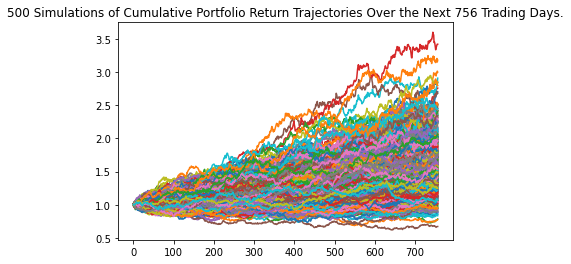

In [30]:
# Plot simulation outcomes
MC_sim_line_plot = MC_threeyear.plot_simulation()

# Save the plot for future use
MC_sim_line_plot.get_figure().savefig("MC_threeyear_sim_plot.png", bbox_inches="tight")


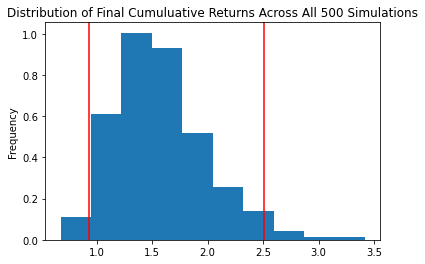

In [31]:
# Plot probability distribution and confidence intervals
MC_sim_dist_plot = MC_threeyear.plot_distribution()

# Save the plot for future use
MC_sim_dist_plot.get_figure().savefig('MC_threeyear_dist_plot.png',bbox_inches='tight')


In [32]:
# Generate summary statistics from the Monte Carlo simulation
# Set the summary statistics equal to a variable for future use
MC_summary_statistics = MC_threeyear.summarize_cumulative_return()

# Print summary statistics Series
print(MC_summary_statistics)


count           500.000000
mean              1.576030
std               0.417742
min               0.671851
25%               1.271811
50%               1.510639
75%               1.808499
max               3.418031
95% CI Lower      0.932108
95% CI Upper      2.506925
Name: 756, dtype: float64


In [33]:
# Using the lower and upper `95%` confidence intervals from the summary statistics,
# calculate the range of the probable cumulative returns for a $10,000 investment
ci_95_lower_cumulative_return = MC_summary_statistics[8] * 10000
ci_95_upper_cumulative_return = MC_summary_statistics[9] * 10000


# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
  f" over the next 3 years will end within in the range of"
  f" ${ci_95_lower_cumulative_return: .2f} and ${ci_95_upper_cumulative_return: .2f}.")


There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 3 years will end within in the range of $ 9321.08 and $ 25069.25.


In [34]:
#Configure a Monte Carlo simulation to forecast one years cumulative returns
MC_oneyear = MCSimulation(
  portfolio_data = price_chart_df,
  weights = [.20, .20, .20, .20, .20],
  num_simulation = 500,
  num_trading_days = 252
)

MC_oneyear.portfolio_data.head().dropna()

BA                                       \
                             open    high       low   close     volume   
time                                                                     
2020-11-17 00:00:00-05:00  200.25  211.20  196.0500  210.02   73949349   
2020-11-18 00:00:00-05:00  223.02  223.02  203.0000  203.20  121049594   
2020-11-19 00:00:00-05:00  200.45  209.44  199.9007  205.56   66289637   
2020-11-20 00:00:00-05:00  204.59  206.58  199.1700  199.62   34789469   

                                        DISCA                       ...  \
                          daily_return   open   high    low  close  ...   
time                                                                ...   
2020-11-17 00:00:00-05:00     0.037648  23.59  24.57  23.47  24.30  ...   
2020-11-18 00:00:00-05:00    -0.032473  24.32  25.05  24.10  24.51  ...   
2020-11-19 00:00:00-05:00     0.011614  24.14  25.19  24.14  25.02  ...   
2020-11-20 00:00:00-05:00    -0.028897  24.90  25.58  24.75  25.46  ...   

                                GL                                  MA  \
                               low  close  volume daily_return    open   
time                                                                     
2020-11-17 00:00:00-05:00  92.2450  93.79  547256     0.003102  333.17   
2020-11-18 00:00:00-05:00  92.3800  92.38  624333    -0.015034  336.53   
2020-11-19 00:00:00-05:00  91.2025  93.35  630365     0.010500  335.49   
2020-11-20 00:00:00-05:00  92.5400  93.22  602223    -0.001393  334.78   

                                                                           
                              high      low   close   volume daily_return  
time                                                                       
2020-11-17 00:00:00-05:00  337.770  330.720  336.50  6146448     0.002742  
2020-11-18 00:00:00-05:00  340.950  334.855  335.94  5687703    -0.001664  
2020-11-19 00:00:00-05:00  339.160  331.420  333.87  4452422    -0.006162  
2020-11-20 00:00:00-05:00  335.155  323.220  323.29  6843330    -0.031689  

[4 rows x 30 columns]

In [35]:
#Run a Monte Carlo simulation to forecast five years cumulative returns
MC_oneyear.calc_cumulative_return()

Running Monte Carlo simulation number:


  0%|          | 0/500 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005538,0.986437,0.995205,1.002862,1.003464,1.007640,1.001797,1.004701,0.996760,1.008883,...,1.004116,1.009300,1.020733,1.021890,1.004509,1.014184,0.997541,1.010089,0.985341,0.992588
2,0.995871,0.986845,1.010869,1.002642,1.004338,1.009092,1.008933,0.999807,0.999655,1.003906,...,1.016640,1.018319,1.023406,1.025566,1.000476,1.026836,1.004074,1.013606,0.971655,0.992214
3,0.997107,0.980164,1.000202,0.994262,1.019827,1.022819,1.014415,1.015076,1.010251,1.003257,...,1.019027,1.012938,1.030545,1.045443,0.988483,1.033573,1.001737,1.003909,0.975580,0.986313
4,1.010454,0.961931,1.000021,1.000505,1.008782,0.994880,1.031609,1.010040,0.998226,0.994337,...,1.016137,1.015590,1.029235,1.047465,0.986388,1.019568,1.009536,1.016042,0.987728,1.001812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1.010037,1.093243,1.153761,1.189984,1.175156,1.680431,1.226400,1.357518,0.900939,1.463265,...,1.215182,1.346335,1.237302,1.307377,1.266622,1.019530,1.353030,1.259951,1.423405,1.553251
249,1.011878,1.102342,1.156725,1.181664,1.172917,1.677339,1.215426,1.335065,0.894809,1.458252,...,1.224015,1.364253,1.241573,1.298803,1.248658,1.010876,1.345759,1.263229,1.427786,1.573515
250,1.017148,1.129994,1.169174,1.180931,1.174434,1.673853,1.197862,1.338095,0.895964,1.467995,...,1.230107,1.366875,1.258724,1.297459,1.220241,1.026063,1.353659,1.257987,1.420354,1.551769
251,1.002535,1.130314,1.165832,1.190842,1.202336,1.686333,1.203854,1.354381,0.904728,1.479688,...,1.218213,1.386885,1.271869,1.302171,1.206417,1.044171,1.338016,1.256695,1.416120,1.547257


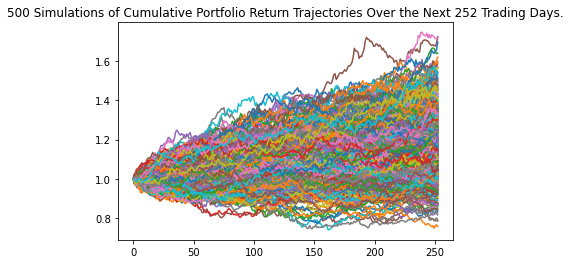

In [36]:
# Plot simulation outcomes
MC_sim_line_plot = MC_oneyear.plot_simulation()

# Save the plot for future use
MC_sim_line_plot.get_figure().savefig("MC_oneyear_sim_plot.png", bbox_inches="tight")


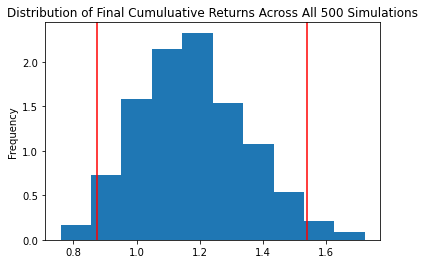

In [37]:
# Plot probability distribution and confidence intervals
MC_sim_dist_plot = MC_oneyear.plot_distribution()

# Save the plot for future use
MC_sim_dist_plot.get_figure().savefig('MC_oneyear_dist_plot.png',bbox_inches='tight')


In [38]:
# Generate summary statistics from the Monte Carlo simulation
# Set the summary statistics equal to a variable for future use
MC_summary_statistics = MC_oneyear.summarize_cumulative_return()

# Print summary statistics Series
print(MC_summary_statistics)


count           500.000000
mean              1.175843
std               0.171488
min               0.759088
25%               1.052169
50%               1.164547
75%               1.289498
max               1.721971
95% CI Lower      0.875449
95% CI Upper      1.537730
Name: 252, dtype: float64


In [39]:
# Using the lower and upper `95%` confidence intervals from the summary statistics,
# calculate the range of the probable cumulative returns for a $10,000 investment
ci_95_lower_cumulative_return = MC_summary_statistics[8] * 10000
ci_95_upper_cumulative_return = MC_summary_statistics[9] * 10000


# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
  f" over the next 1 year will end within in the range of"
  f" ${ci_95_lower_cumulative_return: .2f} and ${ci_95_upper_cumulative_return: .2f}.")


There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 1 year will end within in the range of $ 8754.49 and $ 15377.30.
